In [1]:
%cd /kaggle/input/hetersumgraph-extractive-summary/hetersumgraph

/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph


In [2]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 44.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 57.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 81.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━

In [3]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron

True

In [4]:
%cd /kaggle/input/hetersumgraph-extractive-summary/hetersumgraph

/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph


In [5]:
!ls

dataset  requirements.txt  scripts  utils


In [6]:
%cd /kaggle/input/hetersumgraph-extractive-summary/hetersumgraph

/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph


# Train HeterSUMGraph_CNN_DailyMail

In [7]:
import pandas as pd
import argparse
from time import time
import torch
import numpy as np
import random
from sklearn.utils import shuffle
import json
import os
import networkx as nx
import torch_geometric
from statistics import mean
import matplotlib.pyplot as plt
from tqdm import tqdm
from rouge_score import rouge_scorer
from utils.create_graph_dataset import create_graph_dataset
from utils.GloveMgr import GloveMgr
from utils.DataLoader import DataLoader
from utils.MultiProcessusDataLoader import MultiProcessusDataLoader
from utils.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils.split_all_docs import split_all_docs
from utils.threshold_probs import threshold_probs_by_nb, threshold_probs_by_prop
from utils.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn

## (Hyper-)parameters

In [8]:
import argparse
import sys

# Function to check if running in a notebook
def is_notebook():
    try:
        from IPython import get_ipython
        return 'IPKernelApp' in get_ipython().config
    except ImportError:
        return False

# Parse args if script mode
parser = argparse.ArgumentParser(description='Extractive summary')
parser.add_argument('-is_graphic', type=int, default=1, choices=[0, 1])
parser.add_argument('-gpu_num', type=int, default=0)
parser.add_argument('-batch_size', type=int, default=1)
parser.add_argument('-epochs', type=int, default=5)

args = None

if is_notebook():
    # Use an empty string to avoid parsing additional arguments in notebook/Colab
    args = parser.parse_args("")
else:
    try:
        args = parser.parse_args()
    except SystemExit as e:
        # Handle the exception for unrecognized arguments
        print(f"Argument parsing error: {e}")
        sys.exit(1)

print(args)


Namespace(is_graphic=1, gpu_num=0, batch_size=1, epochs=5)


In [9]:
%cd /kaggle/input/hetersumgraph-extractive-summary/hetersumgraph

/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph


In [10]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.300"

# hyper-parameters
vocab_size = 50000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 5e-4
early_stopping = 3
word_blacklist_proportion = 0.1
model_name = "HeterSUMGraph_CNN_DailyMail"
checkpoints_folder = "/kaggle/working/"
average_number_of_sentences_per_document = 3

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 5
batch_size 1


## PyTorch initialisation

In [11]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [12]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: Tesla P100-PCIE-16GB


In [13]:
if torch.cuda.is_available():
  dev = "cuda:" + str(cuda_num)
else:
  dev = "cpu"

device = torch.device(dev)
device

device(type='cuda', index=0)

## Load data

In [14]:
df_test = pd.read_json("/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph/dataset/test.json")
df_val = pd.read_json("/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph/dataset/val.json")
df_train = pd.read_json("/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph/dataset/train.json")

In [15]:
df_train

,id,article,highlights,labels
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]"
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...,"[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, ..."
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
9995,1c5f649f94e8f20b6fe624a842302208b781edbc,A renowned poet was murdered by her stepson in...,Police found writer's body dead after family r...,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
9996,1c5f8a16032bff0ac292e80d33d9c473323db7aa,(Health.com) -- A class of injectable drugs us...,The research contradicts numerous earlier stud...,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
9997,1c6060b597d97f86d96e7df9ecfc29517f7bbae4,By . Rob Cooper . A mother who accidentally lo...,"Nicola Millar, 36, was unable to pay the fee a...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, ..."
9998,1c613f908ae6868f2d43cfe5ac75c5d35bfd734b,They are hated by many as an eyesore on the co...,Google is developing machines which will be t...,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, ..."


In [16]:
df_test

,id,article,highlights,labels
11200,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]"
11201,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
11202,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,"[1, 1, 0, 1, 0, 0]"
11203,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
11204,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
12195,b8504230c7647905078698183f2dda0ce11b8182,Women travelling on the London Underground are...,Transport for London used actors in the uncomf...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
12196,8f87f30d3cd9eb25ca0759e0dad11befce3f898c,Millions of devout Christians around the world...,WARNING: GRAPHIC CONTENT .\nThe week-long fest...,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12197,788350d50e6858fddaf1095b9ac026d82fae79c1,Floyd Mayweather and Manny Pacquiao may only b...,Floyd Mayweather and Manny Pacquiao fight in L...,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]"
12198,76faa51c29068226495bdaf2d928f176e7d3b8f5,Nigel Farage suffered a fresh blow today after...,ComRes survey for ITV shows Ukip falling behin...,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
df_val

,id,article,highlights,labels
10000,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10001,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10002,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago...","[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ..."
10003,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, ..."
10004,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
11195,9bdd444c65feb6b63b6b0e3db854bfc232d188bc,Dozens of female soldiers have taken part in a...,Soldiers took part in beauty parade to mark In...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11196,6c75c633db19bd5c903cf368d4a715f9e4688337,Sarah Carr (pictured) said that she received a...,Sarah Carr owns three venue and event business...,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11197,414a543c50abfd37977e014fd5df0c792f68f111,It is a problem familiar to anyone whose famil...,Longleat Safari Park to offer bubble wrap cove...,"[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]"
11198,d90fce1d6aef1cfc7e9c8986435cc676c06dd676,MailOnline readers are today given the chance ...,Lib Dem Nick Clegg agrees to answer question s...,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]"


In [18]:
# glovemgr = GloveMgr("./data/glove.6B/glove.6B.300d.txt", vocab_size=vocab_size)
glovemgr = GloveMgr("/kaggle/input/glove6b300dtxt/glove.6B.300d.txt", vocab_size=vocab_size)


In [19]:
#tfidfs_sent = pd.read_json("data/cnn_dailymail_sent_tfidf.json")
tfidfs_sent = pd.read_json("/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph/dataset/cnn_dailymail_sent_tfidf.json")

In [20]:
#tfidfs_dataset = json.load(open("./data/cnn_dailymail_dataset_tfidf.json"))
tfidfs_dataset = json.load(open("/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph/dataset/cnn_dailymail_dataset_tfidf.json"))

tfidfs_dataset_sorted = sorted(tfidfs_dataset, key=tfidfs_dataset.get)
word_blacklist = set(tfidfs_dataset_sorted[:int(word_blacklist_proportion*len(tfidfs_dataset_sorted))])

In [21]:
train_loader = MultiProcessusDataLoader(buffer_size=30, dataset=df_train, batch_size=batch_size, shuffle=True, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False,
                                        doc_column_name="article", labels_column_name="labels", is_sep_n=False, remove_stop_word=True,
                                        stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=100)

In [22]:
val_dataset = create_graph_dataset(df=df_val, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist,
                                   remove_unkn_words=False, doc_column_name="article", labels_column_name="labels",
                                   is_sep_n=False, remove_stop_word=True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=100)
val_loader =  DataLoader(val_dataset, batch_size=1, shuffle=False)

In [23]:
test_dataset = create_graph_dataset(df=df_test, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist,
                                    remove_unkn_words=False, doc_column_name="article", labels_column_name="labels", is_sep_n=False, 
                                    remove_stop_word=True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=100)
test_loader =  DataLoader(test_dataset, batch_size=1, shuffle=False)

## Model

In [24]:
import torch.nn as nn

In [25]:
# own HEADGAT
class GAT(nn.Module):
  def __init__(self, d_hi, d_hj, hidden_size = 64, d_e = 50, num_heads=8) -> None:
    super(GAT, self).__init__()
    self.Wq = nn.Parameter(torch.empty(num_heads, d_hi, hidden_size))#num_heads*nn.Linear(in_features=d_hi, out_features=hidden_size, bias=False)
    nn.init.xavier_uniform_(self.Wq, gain=1.0)
    self.Wk = nn.Parameter(torch.empty(num_heads, d_hj, hidden_size))#num_heads*nn.Linear(in_features=d_hj, out_features=hidden_size, bias=False)
    nn.init.xavier_uniform_(self.Wk, gain=1.0)
    self.Wa = nn.Parameter(torch.empty(num_heads, 2*hidden_size+d_e, 1))#num_heads*nn.Linear(in_features=2*hidden_size+d_e, out_features=1, bias=False)
    nn.init.xavier_uniform_(self.Wa, gain=nn.init.calculate_gain('leaky_relu'))
    self.leaky_relu = nn.LeakyReLU()
    self.Wv = nn.Parameter(torch.empty(num_heads, d_hj, d_hi))#num_heads*nn.Linear(in_features=d_hj, out_features=d_hi, bias=False)
    nn.init.xavier_uniform_(self.Wv, gain=nn.init.calculate_gain('relu'))
    self.num_heads = num_heads

  # hi <- hj (edges orientations)
  def forward(self, Hi, Hj, edge_index_i, edge_index_j, first_i, first_j, edge_attr):
    Q = torch.matmul(Hi.view(1, Hi.shape[0], Hi.shape[1]), self.Wq)
    K = torch.matmul(Hj.view(1, Hj.shape[0], Hj.shape[1]), self.Wk)
    U = []

    # Compute N

    v, c = torch.unique(edge_index_i, return_counts=True, sorted=True)

    tmp_v = torch.arange(Hi.shape[0]).to(Hi.device) + first_i
    tmp_c = torch.zeros(Hi.shape[0], dtype=torch.long).to(Hi.device)

    tmp_c[v - first_i] = c
    c = tmp_c

    tmp_v[v - first_i] = v
    v = tmp_v

    degree_max = torch.max(c).item()

    idxN = torch.zeros(Hi.shape[0] * degree_max, dtype=torch.long).to(Hi.device)
    mask_idxN = torch.arange(degree_max).to(Hi.device).repeat(Hi.shape[0])
    v_idx_sort = torch.argsort(v)
    cn_idxN = torch.repeat_interleave(c[v_idx_sort], degree_max)
    mask_idxN = mask_idxN < cn_idxN

    edge_index_i_argsort = torch.argsort(edge_index_i)
    idxN[mask_idxN] = edge_index_j[edge_index_i_argsort] - first_j

    N = K[:,edge_index_j[edge_index_i_argsort] - first_j]

    # Compute E

    E = edge_attr[edge_index_i_argsort]
    E = E.view(1, edge_attr.shape[0], edge_attr.shape[1])
    E = E.repeat(self.num_heads, 1, 1)

    # Compute T
    c_v_idx_sort = c[v_idx_sort]
    T = torch.repeat_interleave(Q, repeats=c_v_idx_sort, dim=1)

    # Compute A
    A = torch.cat([T, N, E], dim=2)
    A = torch.matmul(A, self.Wa)
    A = A.view(A.shape[0], A.shape[1])

    # Compute Z
    Z = self.leaky_relu(A)

    # Compute alpha
    alpha_1 = Z.clone()
    alpha_2 = torch.full(size=(self.num_heads, Hi.shape[0] * degree_max), fill_value=float('-inf')).to(Hi.device)
    alpha_2[:,mask_idxN] = alpha_1
    alpha_3 = alpha_2.view(self.num_heads, Hi.shape[0], degree_max)
    alpha_3 = torch.softmax(alpha_3, dim=2)
    alpha_4 = alpha_3.view(self.num_heads, Hi.shape[0] * degree_max)
    alpha = alpha_4.clone()
    alpha[torch.isnan(alpha)] = torch.finfo(torch.float32).tiny

    # Compute U
    V = torch.matmul(Hj, self.Wv)
    V = V[:,idxN]

    alpha = alpha.unsqueeze(2)

    U_ = alpha * V
    U_ = U_.view(self.num_heads, Hi.shape[0], degree_max, U_.shape[2])
    U = torch.sum(U_, dim=2)
    U = torch.relu(U)
    U = torch.cat([U[i] for i in range(self.num_heads)], dim=1)

    return U


In [26]:
# Position Feed Forward
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_in, d_out, d_h, dropout=0.1) -> None:
    super(PositionwiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(in_features=d_in, out_features=d_h)
    self.fc2 = nn.Linear(in_features=d_h, out_features=d_out)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

In [27]:
class HeterSUMGraph(torch.nn.Module):
  def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 300, num_iter=3):
    super(HeterSUMGraph, self).__init__()
    self.device = device
    self.num_iter = num_iter

    self.word_emb = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)

    # Load word embedding if specified
    if word_embed is not None:
      self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

    self.word_emb.weight.requires_grad = False

    # edge_attr embed
    self.edge_attr_embed = nn.Embedding(101, 50)

    # sent CNN
    dim_out_cnn = 64
    self.convs = nn.Sequential(
                            nn.Conv1d(in_channels=300,out_channels=100,kernel_size=3,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=100,kernel_size=4,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=dim_out_cnn,kernel_size=5,padding='same'),
                            nn.BatchNorm1d(num_features=dim_out_cnn),
                            nn.ReLU(inplace=True))

    # sent LSTM
    dim_out_lstm = 32
    self.sent_LSTM = nn.LSTM(input_size=300, hidden_size=dim_out_lstm, batch_first=True, bidirectional=True)

    # sent to word GAT
    self.s2wGAT = GAT(d_hi=300, d_hj=128, hidden_size=64, d_e=50, num_heads=8)

    # word to sen GAT
    self.w2sGAT = GAT(d_hi=128, d_hj=300, hidden_size=64, d_e=50, num_heads=8)

    # ffn sent to word
    self.ffns2w = PositionwiseFeedForward(d_in=8*300, d_out=300, d_h=512)

    # ffn word to sent
    self.ffnw2s = PositionwiseFeedForward(d_in=8*128, d_out=128, d_h=512)

    self.wh = nn.Linear(128, 1)

  def max_pool1d(self, x, seq_lens):
    out = []
    for index,t in enumerate(x):
      if seq_lens[index] == 0:
        t = t[:1]
      else:
        t = t[:seq_lens[index],:]
      t = torch.t(t).unsqueeze(0)
      out.append(torch.avg_pool1d(t, t.size(2)))

    out = torch.cat(out).squeeze(2)
    return out

  def forward(self, data):# In the real implémentation remove nb_sent
    # edge attr embeddings
    edge_attr = torch.floor(data.edge_attr * 100).int()
    edge_attr = self.edge_attr_embed(edge_attr)

    # features
    Xw = data.x[0]
    Xs = data.x[1]
    sent_lens = torch.sum(torch.sign(Xs),dim=1).data

    # embeddings
    Xw = self.word_emb(Xw)
    Xs = self.word_emb(Xs)

    # CNN
    XsCNN = self.convs(Xs.permute(0,2,1))
    XsCNN = torch.max_pool1d(XsCNN, XsCNN.size(2)).squeeze(2)

    # LSTM
    # TO DO: ask
    XsLSTM, _ = self.sent_LSTM(Xs)
    XsLSTM = self.max_pool1d(XsLSTM, sent_lens)
    Xs = torch.cat((XsCNN, XsLSTM), dim=1)

    Hw = Xw
    Hs = Xs

    edge_index_w_i = data.edge_index[1][data.edge_index[1] < len(data.x[0])]
    edge_index_s_j = data.edge_index[0][data.edge_index[1] < len(data.x[0])]
    edge_attr_w = edge_attr[data.edge_index[1] < len(data.x[0])]

    edge_index_s_i = data.edge_index[1][data.edge_index[1] >= len(data.x[0])]
    edge_index_w_j = data.edge_index[0][data.edge_index[1] >= len(data.x[0])]
    edge_attr_s = edge_attr[data.edge_index[1] >= len(data.x[0])]

    Hw = torch.layer_norm(Hw, Hw.size()[1:])
    Hs = torch.layer_norm(Hs, Hs.size()[1:])

    for i in range(self.num_iter):
      if i != 0: # H^1w = H^0w = Xw
        Hw = self.s2wGAT(Hi=Hw, Hj=Hs, edge_index_i=edge_index_w_i, edge_index_j=edge_index_s_j, first_i=0, first_j=len(data.x[0]), edge_attr=edge_attr_w) + torch.cat([Hw] * 8, dim=1)
        Hw = self.ffns2w(Hw)
        Hw = torch.layer_norm(Hw, Hw.size()[1:])

      Hs = self.w2sGAT(Hi=Hs, Hj=Hw, edge_index_i=edge_index_s_i, edge_index_j=edge_index_w_j, first_i=len(data.x[0]), first_j=0, edge_attr=edge_attr_s) + torch.cat([Hs] * 8, dim=1)
      Hs = self.ffnw2s(Hs)
      Hs = torch.layer_norm(Hs, Hs.size()[1:])

    res = self.wh(Hs)

    res = torch.sigmoid(res).squeeze(-1)

    return res

  def save(self, fname):
    torch.save(self.state_dict(), fname)

  def load(self, fname):
    self.load_state_dict(torch.load(fname))

## Train

In [28]:
df_val["doc_splitted"] = split_all_docs(df_val["article"])
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [31]:
from time import time
from tqdm import tqdm
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, early_stopping, device, average_number_of_sentences_per_document):
    arr_train_loss = []
    arr_train_mae = []
    arr_train_acc = []
    arr_val_loss = []
    arr_val_mae = []
    arr_val_acc = []

    t1 = time()

    for epoch in range(1, epochs+1):
        # Train
        model.train()
        nb_batch_train = 0
        total_train_loss = 0
        total_train_mae = 0
        total_train_acc = 0
        with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                doc_lens = batch["doc_lens"]
                data = batch["docs"].to(device)
                targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
                y_pred = model(data)

                loss = criterion(y_pred, targets)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 2.0)
                optimizer.step()
                nb_batch_train += 1
                total_train_loss += loss.item()

                probs = y_pred.tolist()
                probs_tensor = y_pred

                total_train_mae += mae_fn(probs_tensor, targets).item()
                total_train_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

                tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)

        # Save model
        model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

        # Eval
        model.eval()
        nb_batch_val = 0
        total_val_loss = 0
        total_val_mae = 0
        total_val_acc = 0
        total_r1 = 0
        total_r2 = 0
        total_rl = 0

        del loss
        del y_pred

        if device != "cpu":
            torch.cuda.empty_cache()

        for i, batch in enumerate(val_loader):
            doc_lens = batch["doc_lens"]
            data = batch["docs"].to(device)
            targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
            y_pred = model(data)

            loss = criterion(y_pred, targets)
            nb_batch_val += 1
            total_val_loss += loss.item()

            doc = val_set["doc_splitted"].iloc[i]
            summaries = val_set["highlights"].iloc[i]

            indices = torch.argsort(y_pred, descending=True)

            y_pred_thresh = []

            txt = ""

            for j in range(min(len(doc), y_pred.shape[0])):
                txt = txt + ". " + doc[indices[j]]
                y_pred_thresh.append(indices[j])
                if len(txt) >= len(summaries):
                    break

            y_pred_thresh.sort()

            txt = ""

            for j in y_pred_thresh:
                txt = txt + ". " + doc[j]

            n = min(len(txt), len(summaries))

            while n < len(txt) and txt[n].isalnum():
                n += 1

            txt = txt[:n]

            scores = scorer.score(summaries, txt)
            total_r1 += scores["rouge1"].fmeasure
            total_r2 += scores["rouge2"].fmeasure
            total_rl += scores["rougeL"].fmeasure

            probs = y_pred.tolist()
            probs_tensor = y_pred

            total_val_mae += mae_fn(probs_tensor, targets).item()
            total_val_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

        if len(arr_val_loss) >= early_stopping+1:
            if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
                print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))
                break

        print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

        del loss
        del y_pred

        if device != "cpu":
            torch.cuda.empty_cache()

        arr_train_loss.append(total_train_loss / nb_batch_train)
        arr_train_mae.append(total_train_mae / nb_batch_train)
        arr_train_acc.append(total_train_acc / nb_batch_train)

        arr_val_loss.append(total_val_loss / nb_batch_val)
        arr_val_mae.append(total_val_mae / nb_batch_val)
        arr_val_acc.append(total_val_acc / nb_batch_val)

    t2 = time()
    print("Training duration =", t2-t1)
    return arr_train_loss, arr_train_mae, arr_train_acc, arr_val_loss, arr_val_mae, arr_val_acc




In [32]:
%cd /kaggle/input/hetersumgraph-extractive-summary/hetersumgraph

/kaggle/input/hetersumgraph-extractive-summary/hetersumgraph


In [33]:
# Set up training parameters and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeterSUMGraph(device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings(), dim_word_embed=300, num_iter=3).to(device)
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)



In [34]:
# Call the train_model function\
average_number_of_sentences_per_document = 3

arr_train_loss ,arr_train_mae ,arr_train_acc ,arr_val_loss, arr_val_mae ,arr_val_acc = train_model(model, train_loader, val_loader, criterion, 
optimizer, epochs=8, early_stopping=3, device=device,average_number_of_sentences_per_document=average_number_of_sentences_per_document)


Epoch 1:   0%|          | 0/10000 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1: 100%|██████████| 10000/10000 [13:25<00:00, 12.41batch/s, accuracy=0.751, loss=0.523, mae=0.338]


Epoch 1 : val loss = 0.532, val mae = 0.333, val accuracy = 0.745, r1 = 0.355, r2 = 0.131, rL = 0.227


Epoch 2: 100%|██████████| 10000/10000 [13:23<00:00, 12.45batch/s, accuracy=0.772, loss=0.506, mae=0.325]


Epoch 2 : val loss = 0.523, val mae = 0.342, val accuracy = 0.757, r1 = 0.374, r2 = 0.144, rL = 0.238


Epoch 3: 100%|██████████| 10000/10000 [13:21<00:00, 12.48batch/s, accuracy=0.778, loss=0.497, mae=0.319]


Epoch 3 : val loss = 0.522, val mae = 0.354, val accuracy = 0.760, r1 = 0.377, r2 = 0.148, rL = 0.240


Epoch 4: 100%|██████████| 10000/10000 [13:21<00:00, 12.48batch/s, accuracy=0.783, loss=0.488, mae=0.312]


Epoch 4 : val loss = 0.520, val mae = 0.331, val accuracy = 0.760, r1 = 0.376, r2 = 0.147, rL = 0.239


Epoch 5: 100%|██████████| 10000/10000 [13:19<00:00, 12.51batch/s, accuracy=0.79, loss=0.476, mae=0.304]


Epoch 5 : val loss = 0.533, val mae = 0.322, val accuracy = 0.751, r1 = 0.364, r2 = 0.137, rL = 0.232


Epoch 6: 100%|██████████| 10000/10000 [13:19<00:00, 12.51batch/s, accuracy=0.798, loss=0.463, mae=0.294]


Epoch 6 : val loss = 0.534, val mae = 0.348, val accuracy = 0.753, r1 = 0.372, r2 = 0.143, rL = 0.237


Epoch 7: 100%|██████████| 10000/10000 [13:22<00:00, 12.46batch/s, accuracy=0.807, loss=0.446, mae=0.281]


Epoch 7 : val loss = 0.539, val mae = 0.319, val accuracy = 0.754, r1 = 0.369, r2 = 0.139, rL = 0.233


Epoch 8: 100%|██████████| 10000/10000 [13:18<00:00, 12.53batch/s, accuracy=0.815, loss=0.428, mae=0.267]


Epoch 8 : val loss = 0.539, val mae = 0.338, val accuracy = 0.751, r1 = 0.366, r2 = 0.137, rL = 0.230
Training duration = 6803.784394741058


## Eval model

In [35]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
best_epoch

4

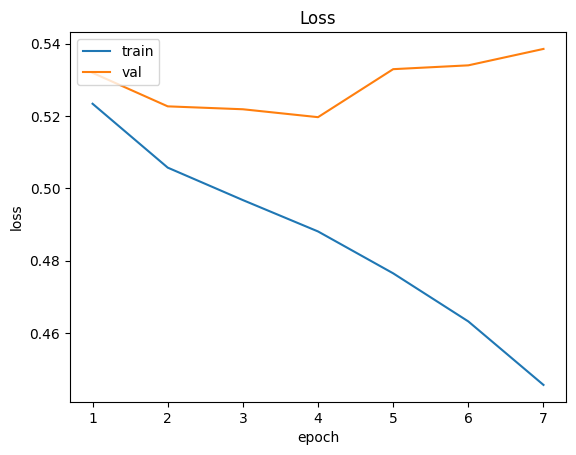

In [36]:
# draw Losses
if is_graphic:
  plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
  plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(loc="upper left")

  plt.show()

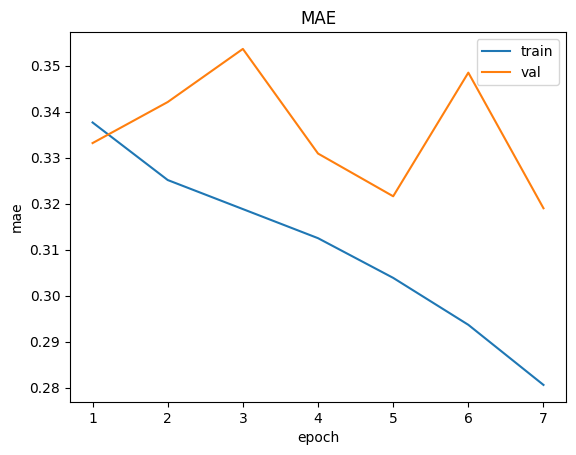

In [37]:
if is_graphic:
  plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
  plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

  plt.title("MAE")
  plt.xlabel("epoch")
  plt.ylabel("mae")
  plt.legend(loc="upper right")

  plt.show()

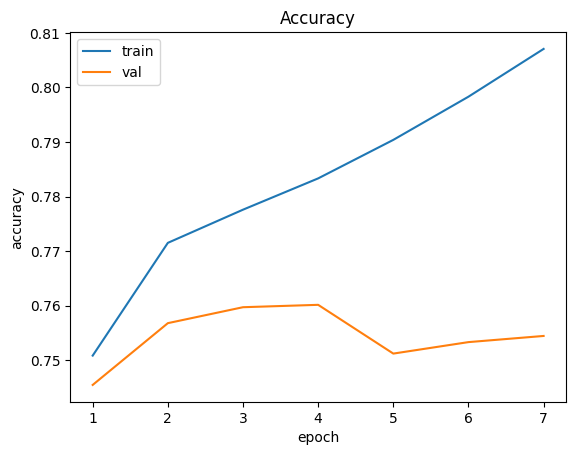

In [38]:
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
  plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

In [39]:
df_test["doc_splitted"] = split_all_docs(df_test["article"], False)
test_set = df_test

In [40]:
def test(model, test_loader, test_set, device, criterion, mae_fn, average_number_of_sentences_per_document):
    model.eval()  

    arr_rouge1 = []
    arr_rouge2 = []
    arr_rougeL = []
    arr_loss = []
    mae = []
    accuracy = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    idx = 0
    with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
        for batch in tepoch:
            tepoch.set_description("Eval model")
            data = batch["docs"].to(device)
            targets = torch.tensor(batch["labels"], dtype=torch.float).to(device)
            y_pred = model(data)

            # Tính toán loss
            loss = criterion(y_pred, targets)
            arr_loss.append(loss.item())

            doc = test_set["doc_splitted"].iloc[idx]
            summaries = test_set["highlights"].iloc[idx]

            # Sắp xếp các dự đoán theo độ tin cậy
            indices = torch.argsort(y_pred, descending=True)
            y_pred_thresh = []

            txt = ""
            for i in range(min(len(doc), y_pred.shape[0])):
                txt = txt + ". " + doc[indices[i]]
                y_pred_thresh.append(indices[i])
                if len(txt) >= len(summaries):
                    break

            y_pred_thresh.sort()
            txt = ""
            for i in y_pred_thresh:
                txt = txt + ". " + doc[i]

            n = min(len(txt), len(summaries))
            while n < len(txt) and txt[n].isalnum():
                n += 1

            txt = txt[:n]

            # Tính toán các chỉ số ROUGE
            scores = scorer.score(summaries, txt)
            arr_rouge1.append(scores["rouge1"].fmeasure)
            arr_rouge2.append(scores["rouge2"].fmeasure)
            arr_rougeL.append(scores["rougeL"].fmeasure)

            # Tính toán MAE và accuracy
            probs_tensor = y_pred  # Không cần chuyển đổi lại thành tensor
            mae.append(mae_fn(probs_tensor, targets).item())
            accuracy.append(accuracy_nb_sent_per_doc_fn(probs=y_pred.cpu().detach().numpy(),
                                                         targets=targets.cpu().detach().numpy(),
                                                         doc_lens=[len(y_pred)],
                                                         average_number_of_sentences_per_document=average_number_of_sentences_per_document))

            tepoch.set_postfix(loss=np.mean(arr_loss),
                               rouge1=np.mean(arr_rouge1),
                               rouge2=np.mean(arr_rouge2),
                               rougeL=np.mean(arr_rougeL),
                               accuracy=np.mean(accuracy))
            idx += 1

    return {
        'loss': np.mean(arr_loss),
        'rouge1': np.mean(arr_rouge1),
        'rouge2': np.mean(arr_rouge2),
        'rougeL': np.mean(arr_rougeL),
        'mae': np.mean(mae),
        'accuracy': np.mean(accuracy)
    }


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HeterSUMGraph(device=device, vocab_size=vocab_size,  word_embed=glovemgr.getEmbeddings())  # Thay thế word_embed với embeddings thực tế của bạn
model_path = checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt"# Đường dẫn tới mô hình
model.load(model_path)
model.to(device)

criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

results = test(model, test_loader, df_test, device, criterion, mae_fn, average_number_of_sentences_per_document)

print("Evaluation results:")
print(f"Loss: {results['loss']}")
print(f"ROUGE-1: {results['rouge1']}")
print(f"ROUGE-2: {results['rouge2']}")
print(f"ROUGE-L: {results['rougeL']}")
print(f"MAE: {results['mae']}")
print(f"Accuracy: {results['accuracy']}")

Eval model: 100%|██████████| 1000/1000 [00:42<00:00, 23.45batch/s, accuracy=0.756, loss=0.524, rouge1=0.364, rouge2=0.14, rougeL=0.233]


Evaluation results:
Loss: 0.5242460510283709
ROUGE-1: 0.3640771953019888
ROUGE-2: 0.13993838657291094
ROUGE-L: 0.2331689240927057
MAE: 0.33616727136075497
Accuracy: 0.7560965247980753


In [43]:
results = {
    'Metric': ['Loss', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'MAE', 'Accuracy'],
    'Value': [
        0.5242460510283709,
        0.3640771953019888,
        0.13993838657291094,
        0.2331689240927057,
        0.33616727136075497,
        0.7560965247980753
    ]
}

results_df = pd.DataFrame(results)

results_df['Value'] = results_df['Value'].round(3)

results_df

,Metric,Value
0,Loss,0.524
1,ROUGE-1,0.364
2,ROUGE-2,0.140
3,ROUGE-L,0.233
4,MAE,0.336
5,Accuracy,0.756


### Lead-3

In [44]:
def lead_3_summarizer(doc):
    return ". ".join(doc[:3])

def evaluate_lead_3(test_loader, test_set, scorer):
    arr_rouge1 = []
    arr_rouge2 = []
    arr_rougeL = []
    idx = 0

    with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
        for batch in tepoch:
            tepoch.set_description("Lead-3")
            doc = test_set["doc_splitted"].iloc[idx]
            summaries = test_set["highlights"].iloc[idx]

            # Tạo tóm tắt Lead-3
            txt = lead_3_summarizer(doc)

            # Xác định điểm dừng của tóm tắt
            n = min(len(txt), len(summaries))
            while n < len(txt) and txt[n].isalnum():
                n += 1
            txt = txt[:n]

            # Tính toán ROUGE scores
            scores = scorer.score(summaries, txt)
            arr_rouge1.append(scores["rouge1"].fmeasure)
            arr_rouge2.append(scores["rouge2"].fmeasure)
            arr_rougeL.append(scores["rougeL"].fmeasure)

            idx += 1

            tepoch.set_postfix(rouge1=np.mean(arr_rouge1), rouge2=np.mean(arr_rouge2), rougeL=np.mean(arr_rougeL))

    # Tính toán trung bình cho tất cả các giá trị
    mean_rouge1 = np.mean(arr_rouge1)
    mean_rouge2 = np.mean(arr_rouge2)
    mean_rougeL = np.mean(arr_rougeL)

    results = {
        "rouge1": mean_rouge1,
        "rouge2": mean_rouge2,
        "rougeL": mean_rougeL
    }

    print(f"Lead-3 ROUGE-1: {mean_rouge1:.3f}, ROUGE-2: {mean_rouge2:.3f}, ROUGE-L: {mean_rougeL:.3f}")

    return results



In [45]:
# Giả sử bạn đã có test_set, test_loader và scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
results = evaluate_lead_3(test_loader, test_set, scorer)

Lead-3: 100%|██████████| 1000/1000 [00:14<00:00, 71.18batch/s, rouge1=0.398, rouge2=0.166, rougeL=0.248]


Lead-3 ROUGE-1: 0.398, ROUGE-2: 0.166, ROUGE-L: 0.248


In [47]:
results = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Value': [
        0.39761038364249474,
        0.1663224995626377,
        0.24774195084292322
    ]
}

# Chuyển dictionary thành DataFrame
results_df = pd.DataFrame(results)

# Làm tròn các giá trị đến 3 chữ số thập phân
results_df['Value'] = results_df['Value'].round(3)

# In DataFrame
results_df


,Metric,Value
0,ROUGE-1,0.398
1,ROUGE-2,0.166
2,ROUGE-L,0.248


### First n char

In [48]:
def evaluate_first_n_char(test_loader, test_set, scorer):
    
    arr_rouge1 = []
    arr_rouge2 = []
    arr_rougeL = []
    mae = []
    accuracy = []

    idx = 0
    with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
        for batch in tepoch:
            tepoch.set_description("First-n-char")
            doc = test_set["doc_splitted"].iloc[idx]

            txt = ""
            for i in range(len(doc)):
                txt = txt + doc[i]

            summaries = test_set["highlights"].iloc[idx]

            n = min(len(txt), len(summaries))

            while n < len(txt) and txt[n].isalnum():
                n += 1

            txt = txt[:n]

            scores = scorer.score(summaries, txt)
            arr_rouge1.append(scores["rouge1"].fmeasure)
            arr_rouge2.append(scores["rouge2"].fmeasure)
            arr_rougeL.append(scores["rougeL"].fmeasure)

            idx += 1

            tepoch.set_postfix(rouge1=np.mean(arr_rouge1), rouge2=np.mean(arr_rouge2), rougeL=np.mean(arr_rougeL))

    mean_rouge1 = np.mean(arr_rouge1)
    mean_rouge2 = np.mean(arr_rouge2)
    mean_rougeL = np.mean(arr_rougeL)

    results = {
        "rouge1": mean_rouge1,
        "rouge2": mean_rouge2,
        "rougeL": mean_rougeL
    }

    print(f"First-n-char ROUGE-1: {mean_rouge1:.3f}, ROUGE-2: {mean_rouge2:.3f}, ROUGE-L: {mean_rougeL:.3f}")

    return results



In [49]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
results = evaluate_first_n_char(test_loader, test_set, scorer)

First-n-char: 100%|██████████| 1000/1000 [00:14<00:00, 70.04batch/s, rouge1=0.402, rouge2=0.169, rougeL=0.25]

First-n-char ROUGE-1: 0.402, ROUGE-2: 0.169, ROUGE-L: 0.250


In [51]:
results

{'rouge1': 0.4022823066603161,
 'rouge2': 0.16930362429304213,
 'rougeL': 0.24994209489686414}

In [52]:
results = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Value': [0.4022823066603161, 0.16930362429304213, 0.24994209489686414]
}

results_df = pd.DataFrame(results)

results_df['Value'] = results_df['Value'].round(3)


results_df



,Metric,Value
0,ROUGE-1,0.402
1,ROUGE-2,0.169
2,ROUGE-L,0.250


# Use model

In [58]:
# Initialize model
# model = HeterSUMGraph(device=device, vocab_size=vocab_size,  word_embed=glovemgr.getEmbeddings())  # Thay thế word_embed với embeddings thực tế của bạn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeterSUMGraph(device=device, vocab_size=50000,  word_embed=glovemgr.getEmbeddings())
model.load(model_path)
model.to(device)

HeterSUMGraph(
  (word_emb): Embedding(50002, 300, padding_idx=0)
  (word_embedding): Embedding(50002, 300)
  (edge_attr_embed): Embedding(101, 50)
  (convs): Sequential(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(100, 100, kernel_size=(4,), stride=(1,), padding=same)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(100, 64, kernel_size=(5,), stride=(1,), padding=same)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (sent_LSTM): LSTM(300, 32, batch_first=True, bidirectional=True)
  (s2wGAT): GAT(
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (w2sGAT): GAT(
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (ffns2w): PositionwiseFeedForward(
    (fc1): Linea

In [59]:
import torch
from tqdm import tqdm

def use_model(model, test_loader, test_set, device):
    model.eval()

    idx = 0
    all_summaries = []

    with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
        for batch in tepoch:
            tepoch.set_description("Using model")
            data = batch["docs"].to(device)
            
            y_pred = model(data)

            doc = test_set["doc_splitted"].iloc[idx]
            summaries = test_set["highlights"].iloc[idx]
            
            # Sắp xếp các dự đoán theo độ tin cậy
            indices = torch.argsort(y_pred, descending=True)
            y_pred_thresh = []

            txt = ""
            for i in range(min(len(doc), y_pred.shape[0])):
                txt = txt + ". " + doc[indices[i]]
                y_pred_thresh.append(indices[i])
                if len(txt) >= len(summaries):
                    break

            y_pred_thresh.sort()
            txt = ""
            for i in y_pred_thresh:
                txt = txt + ". " + doc[i]

            all_summaries.append({
                'original': " ".join(doc),
                'summary': txt
            })

            idx += 1

    return all_summaries


In [60]:
def save_summaries_to_file(summaries, file_path):
    with open(file_path, 'w') as f:
        for i, summary in enumerate(summaries):
            f.write(f"Document {i+1} (Original):\n")
            f.write(f"{summary['original']}\n\n")
            f.write(f"Summary:\n")
            f.write(f"{summary['summary']}\n\n")
            f.write("="*50 + "\n\n")

In [61]:
examples = use_model(model, test_loader, test_set, device)

Using model: 100%|██████████| 1000/1000 [00:35<00:00, 27.98batch/s]


In [62]:
file_path = "/kaggle/working/summaries_2.txt"
save_summaries_to_file(examples, file_path)